# Mango Disease Classification

## Import all dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt



## Set all the constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

## Import data into tensorflow dataset object

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "MangoDB/train",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "MangoDB/test",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 3200 files belonging to 8 classes.
Found 800 files belonging to 8 classes.


In [4]:
class_names = train_dataset.class_names
class_names

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

In [5]:
len(train_dataset)

100

In [6]:
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 3 6 1 5 6 0 4 3 1 0 6 4 6 1 4 0 7 2 3 7 6 5 3 4 0 6 0 2 3 4 2]


## Visualize the images in the dataset

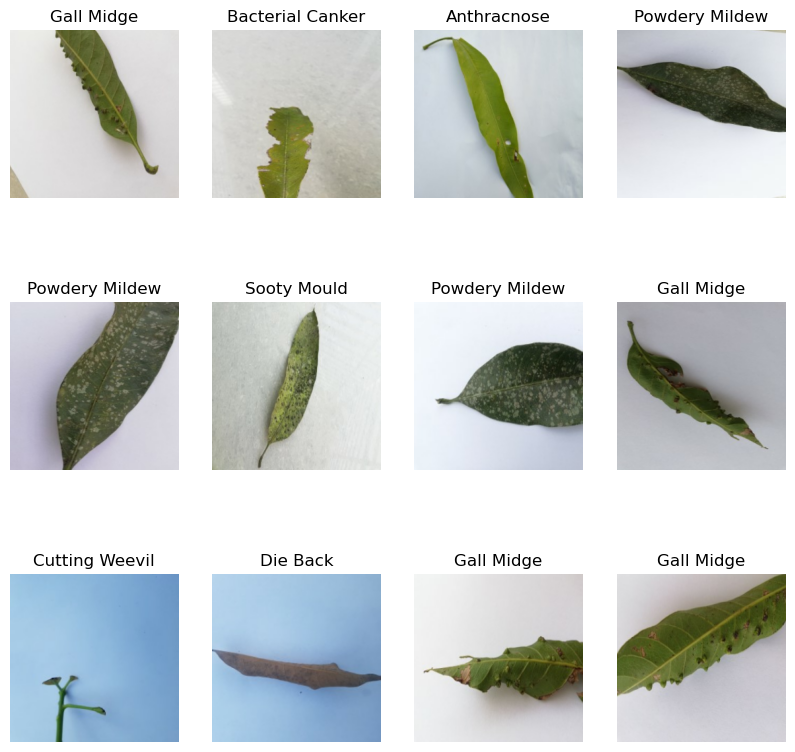

In [7]:
# training batch
plt.figure(figsize=(10,10))
for images_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

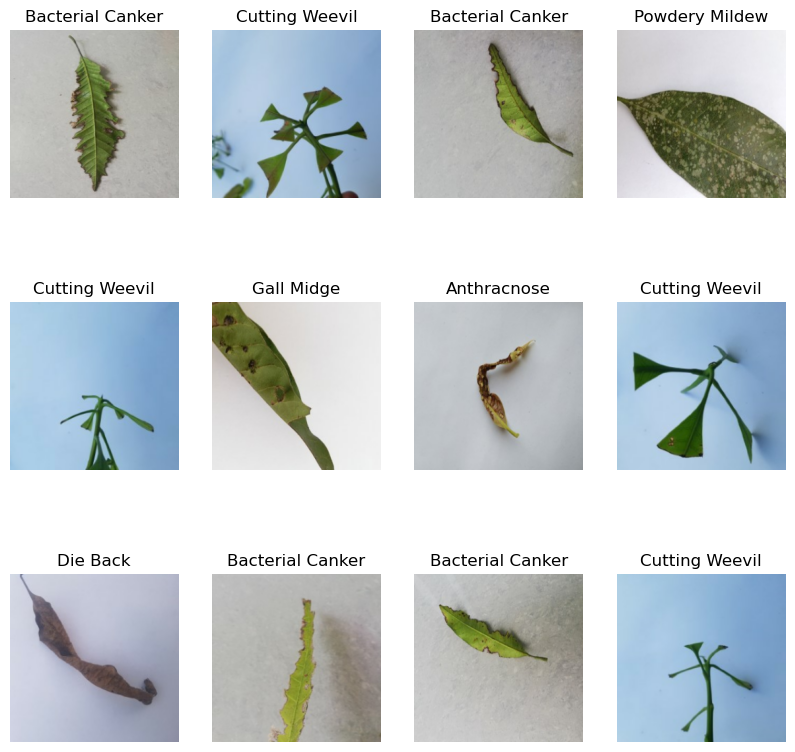

In [8]:
# testing batch
plt.figure(figsize=(10,10))
for images_batch, label_batch in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
len(train_dataset)

100

In [10]:
train_size = 0.8
len(train_dataset)*train_size

80.0

In [11]:
train_ds = train_dataset.take(80)
len(train_ds)

80

In [21]:
test_ds = train_dataset.skip(80)
len(test_ds)

20

In [22]:
val_size = 0.1
len(train_dataset)*val_size

10.0

In [23]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [24]:
test_ds = test_ds.skip(10)
len(test_ds)

10

In [25]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds = get_dataset_partition(train_dataset)

In [27]:
len(train_ds)


80

In [28]:
len(val_ds)

10

In [29]:
len(test_ds)

10

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model
### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [34]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [35]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [39]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3,), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3,), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3,), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [42]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


80/80 [==============================] - 101s 749ms/step - loss: 1.7738 - accuracy: 0.2539 - val_loss: 1.7278 - val_accuracy: 0.2906
Epoch 2/50
80/80 [==============================] - 33s 417ms/step - loss: 1.4532 - accuracy: 0.3918 - val_loss: 1.3117 - val_accuracy: 0.4469
Epoch 3/50
80/80 [==============================] - 23s 282ms/step - loss: 1.1440 - accuracy: 0.5496 - val_loss: 1.1246 - val_accuracy: 0.5688
Epoch 4/50
80/80 [==============================] - 17s 217ms/step - loss: 0.9123 - accuracy: 0.6477 - val_loss: 0.8091 - val_accuracy: 0.6906
Epoch 5/50
80/80 [==============================] - 17s 216ms/step - loss: 0.6778 - accuracy: 0.7324 - val_loss: 0.8903 - val_accuracy: 0.6687
Epoch 6/50
80/80 [==============================] - 17s 217ms/step - loss: 0.6467 - accuracy: 0.7539 - val_loss: 0.6302 - val_accuracy: 0.7906
Epoch 7/50
80/80 [==============================] - 17s 214ms/step - loss: 0.4896 - accuracy: 0.8164 - val_loss: 0.4489 - val_accuracy: 0.8406
Epoch 8/5

In [43]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 16s 45ms/step - loss: 0.1999 - accuracy: 0.9344


In [ ]:
scores

### Plotting the Accuracy and Loss Curves

In [44]:
history

In [45]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 80}

In [46]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

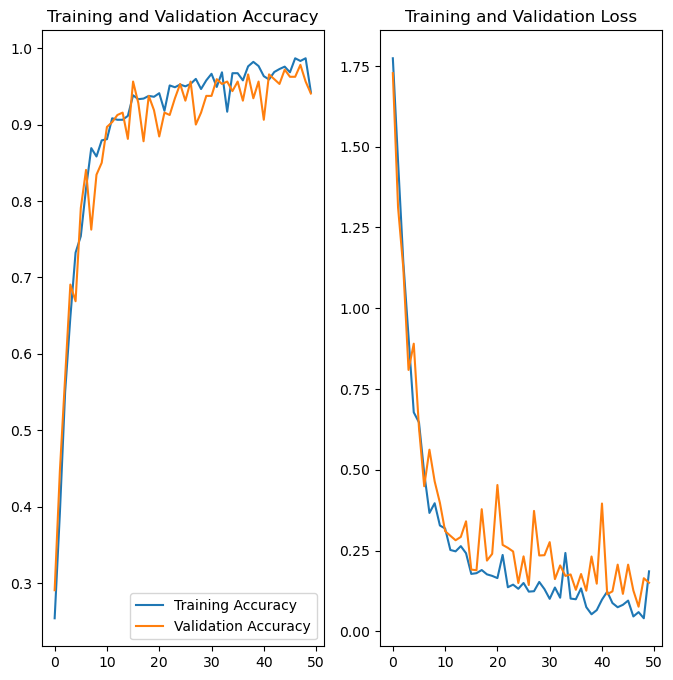

In [48]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Traning Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')

plt.show()

In [49]:
import numpy as np

First image to predict
Actual label:  Anthracnose
1/1 [==============================] - 0s 324ms/step
Predicted label:  Anthracnose


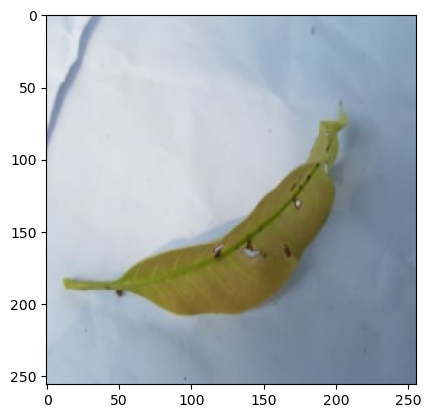

In [50]:
for images_batch, label_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print('First image to predict')
    plt.imshow(first_image)
    print('Actual label: ', class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print('Predicted label: ',class_names[np.argmax(batch_prediction[0])])

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


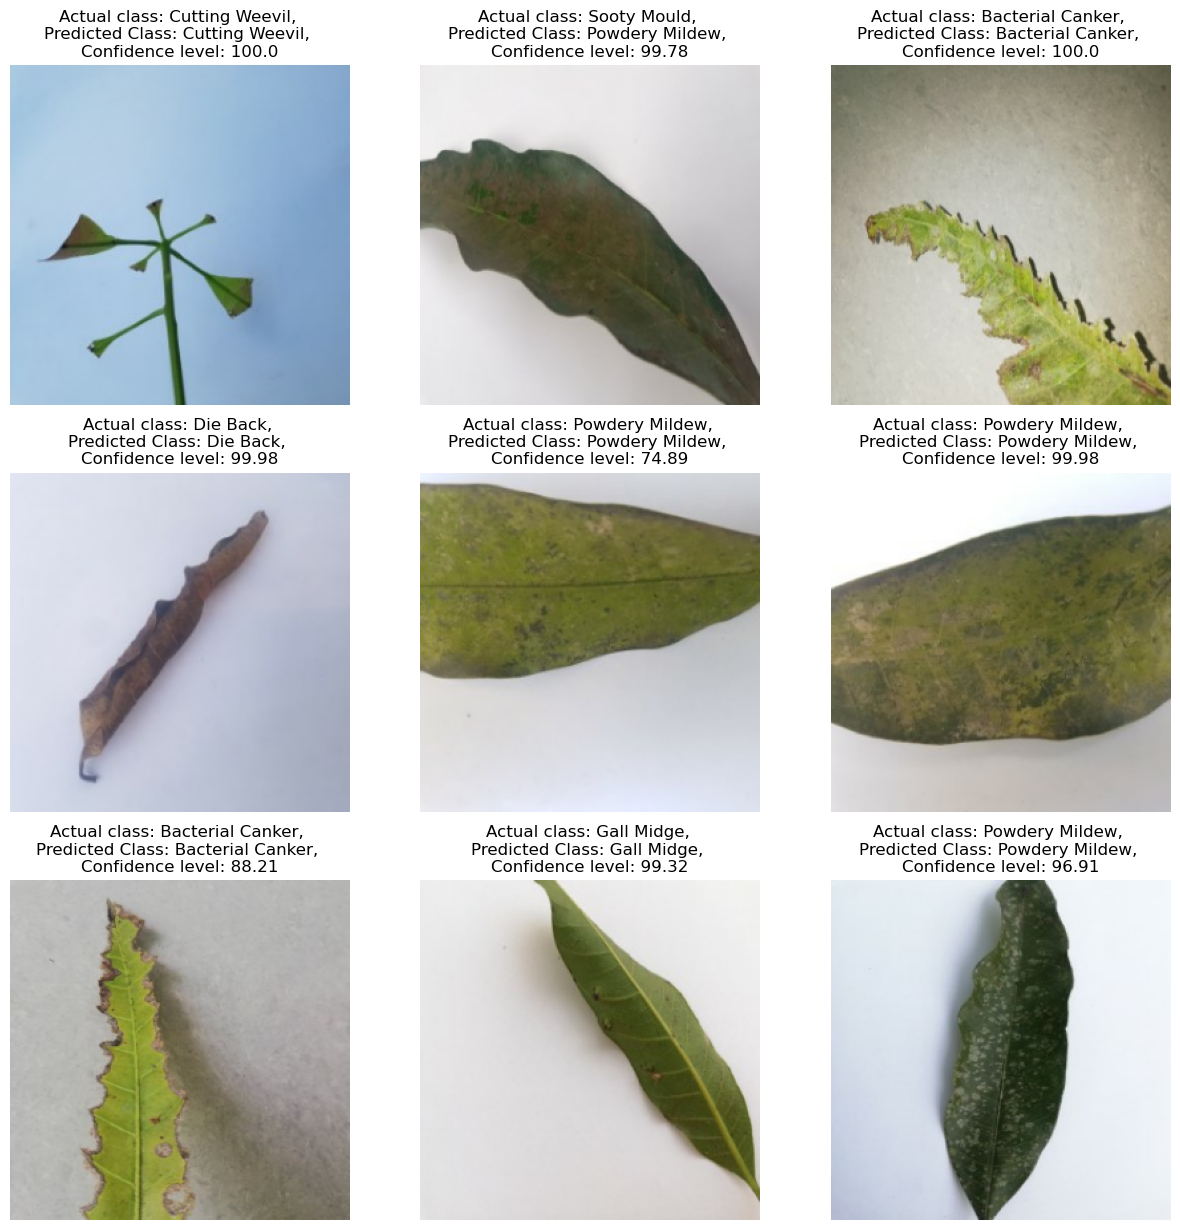

In [52]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual class: {actual_class}, \nPredicted Class: {predicted_class}, \nConfidence level: {confidence}")

        plt.axis('off')


In [53]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]]) + 1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/4\assets


INFO:tensorflow:Assets written to: ../saved_models/4\assets


In [54]:
model.save("../mangoes.h5")

In [ ]:
import tensorflow as tf

# Assume 'model' is your trained TensorFlow model
model = tf.keras.models.load_model('output_files/fruit-360 model/model_final.h5')

# Save the model as a TensorFlow SavedModel
tf.saved_model.save(model, 'output_files/tfmodel')

In [2]:
import tensorflow as tf

saved_model_dir = '../saved_models/4/'

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

743200